# Experiments
Here I loaded the models trained before for testing them separately. 
I decided to do so in order to have a better view of the results without running everything from the main jupyter notebook.

# Imports

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from multiprocessing import Pool
import random
import matplotlib
import tensorflow as tf

In [2]:
# AES sbox
def read_data(file_loc, raw=False):
    """
    Reads in the ASCAD h5 dataset from the given dir_loc. If raw = False, reads ASCAD.h5 and assumes the simplified dataset structure.
    If raw = True, reads ATMega8515_raw_traces.h5 and assumes the raw traces dataset structure. 
    Returns the tuple: (x_train, x_test, plt_train, plt_test, keys_train, keys_test)
    :dir_loc: directory where the ASCAD dataset is located. Default = 'F:\\ASCAD\\ATMEGA_AES_v1\\ATM_AES_v1_fixed_key\\ASCAD_data\\ASCAD_databases\\'
    :data_name: Dataset name. Default = 'ASCAD.h5'
    """
    with h5py.File(file_loc, "r") as in_file:
        # Load traces
        x_train = np.array(
            in_file['Profiling_traces/traces'], dtype=np.int8)
        x_test = np.array(in_file['Attack_traces/traces'], dtype=np.int8)
        # labels are sbox(plt[2] XOR key[2])
        
        labels_train = np.array(in_file['Profiling_traces/labels'])
        labels_test = np.array(in_file['Attack_traces/labels'])
        
        plt_train = np.array(
            in_file['Profiling_traces/metadata']['plaintext'])
        plt_test = np.array(in_file['Attack_traces/metadata']['plaintext'])

        keys_train = np.array(in_file['Profiling_traces/metadata']['key'])
        keys_test = np.array(in_file['Attack_traces/metadata']['key'])
        
        masks_train = np.array(in_file['Profiling_traces/metadata']['masks'])
        masks_test = np.array(in_file['Attack_traces/metadata']['masks'])
        
        return x_train, x_test, labels_train, labels_test, plt_train, plt_test, keys_train, keys_test, masks_train, masks_test
sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
])
def snr(obs_value, traces):
    max_val = np.max(obs_value)
    means = [None] * (max_val + 1)
    varss = [None] * (max_val + 1)
    for i in range(max_val + 1):
        means[i] = np.mean(traces[obs_value == i], axis=0)
        varss[i] = np.var(traces[obs_value == i], axis=0)
    means = np.array(means)
    varss = np.array(varss)
    snr = np.zeros_like(means[0])
    u_tot = np.mean(means, axis=0)
    v_tot = np.mean(varss, axis=0)
    for i in range(max_val + 1):
        snr += np.power(means[i]-u_tot, 2)
    snr = snr / v_tot
    return snr
def partial_key(key_guess, attack_byte, pt, traces): # ^ = XOR
    # xoring plaintext with key guess
    hypotheses = np.array([HW[sbox[pt[i, attack_byte] ^ key_guess]] for i in range(pt.shape[0])])
    # we use the hypotheses and calculate the correlation
    
    return np.max(np.corrcoef(hypotheses, traces, rowvar=False)[0, 1:])
def random_subset(size, *a):
    """
    Takes a random subset of size :size: from the given arrays. Makes sure that the rows of the arrays still match after shuffling.
    Example usage: subset_train, subset_labels = random_subset(10, training_set, training_labels)

    :size: size of the subset
    :*a: arrays to take subset of
    """
    combined = list(zip(*a))
    random.shuffle(combined)
    b = [np.array(i)[:size] for i in zip(*combined)]

    return b

def ge_sr(traces, plaintext, key, byte, model, success_cutoff, nr_attack_traces, averaging_nr, track=False, data_augment=None):
    """
    Returns (guessing entropy, success rate) tuple of the given model over the given traces

    :traces: all available attacking traces
    :plaintext: all corresponding plaintext
    :key: the real key
    :byte: byte of key to attack
    :model: model used for making predictions
    :success_cutoff: cutoff to calculate success rate (key rank < success_cutoff)
    :nr_attack_traces: number of traces to use for attacking
    :averaging_nr: number of times to perform attack on subtraces in order to calculate the guessing entropy and success rate
    :track: boolean to indicate whether the guessing entropy should be tracked for each trace amount up to :nr_attack_traces:
    :data_augment: Default None. If not None, should be a function which takes traces as input and returns the augmented traces.
    """

    if track:
        key_ranks = np.zeros((averaging_nr, nr_attack_traces))
        successes = np.zeros((averaging_nr, nr_attack_traces))
    else:
        key_ranks = np.zeros((averaging_nr))
        successes = np.zeros((averaging_nr))

    for run in tqdm(range(averaging_nr), desc="run", leave=False):
        # take a random subset from the attacking traces
        attack_traces, attack_plaintext = random_subset(
            nr_attack_traces, traces, plaintext)

        if data_augment:
            print(f"applying data augmentation")
            attack_traces = data_augment(attack_traces)
        
        # make predictions: probability of each label, where label = sbox[plt[byte] ^ key[byte]]
        predictions = model(attack_traces, training=False)

        # convert probability to log values
        predictions = np.log(predictions+1e-20)
        _, leakage_mdl = predictions.shape
            
        # set the key probabilities to 0 for each key hypothesis
        key_probabilities = np.zeros(256)

        # for each trace, add up the log(probability) of each key hypothesis
        for i in tqdm(range(nr_attack_traces), desc='attack', leave=False):
            for k in range(256):
                if leakage_mdl == 9:
                    key_probabilities[k] += predictions[i, HW[sbox[attack_plaintext[i, byte] ^ k]]]
                else:
                    key_probabilities[k] += predictions[i, sbox[attack_plaintext[i, byte] ^ k]]

            # if tracking per trace, then add to key_ranks and successes array here
            if track:
                # now key_probabilities contains estimated key probability after i traces
                key_rank = list(np.argsort(key_probabilities)
                                [::-1]).index(key[byte])
                success = int(key_rank < success_cutoff)

                key_ranks[run, i] = key_rank
                successes[run, i] = success

        # if not tracking per trace, only add to key_ranks and successes array after all traces are attacked
        if not track:
            # now key_probabilities contains the estimated key probability of each key after the full attack
            # argsort()[::-1] -> sorts key values from most likely to least likely. Then get index of actual key byte to get the key rank.
            key_rank = list(np.argsort(key_probabilities)
                            [::-1]).index(key[byte])

            success = int(key_rank < success_cutoff)

            key_ranks[run] = key_rank
            successes[run] = success

    return np.mean(key_ranks, axis=0), np.mean(successes, axis=0)

## Loading the MLP model

In [3]:
model_mlp = tf.keras.models.load_model('log_mpl')
model_mlp.summary()
#model_cnn = tf.keras.models.load_model('log')

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-06-04 18:10:41.969482: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-04 18:10:41.969506: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_125 (Dense)           (None, 200)               20200     
                                                                 
 dense_126 (Dense)           (None, 200)               40200     
                                                                 
 dense_127 (Dense)           (None, 200)               40200     
                                                                 
 dense_128 (Dense)           (None, 200)               40200     
                                                                 
 dense_129 (Dense)           (None, 200)               40200     
                                                                 
 dense_130 (Dense)           (None, 256)               51456     
                                                                 
Total params: 232456 (908.03 KB)
Trainable params: 23

## Loading the dataset

In [4]:

x_train, x_test, labels_train, labels_test, plt_train, plt_test, keys_train, keys_test, masks_train, masks_test = read_data('Base_desync0.h5')

# Preprocessing
I used the PCA to reduce the dimensionality to 100 features.

In [5]:
attack_byte = 2
from sklearn.decomposition import PCA
pca =PCA(n_components=100)
X_train = pca.fit_transform(x_train)
X_test = pca.transform(x_test)

# Testing

In [7]:
!jupyter nbextension enable --py widgetsnbextension
ge, sr=ge_sr(X_test, plt_test, keys_test[0], attack_byte, model_mlp,success_cutoff=1,nr_attack_traces=600,averaging_nr=100, track=True)


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


run:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

[]

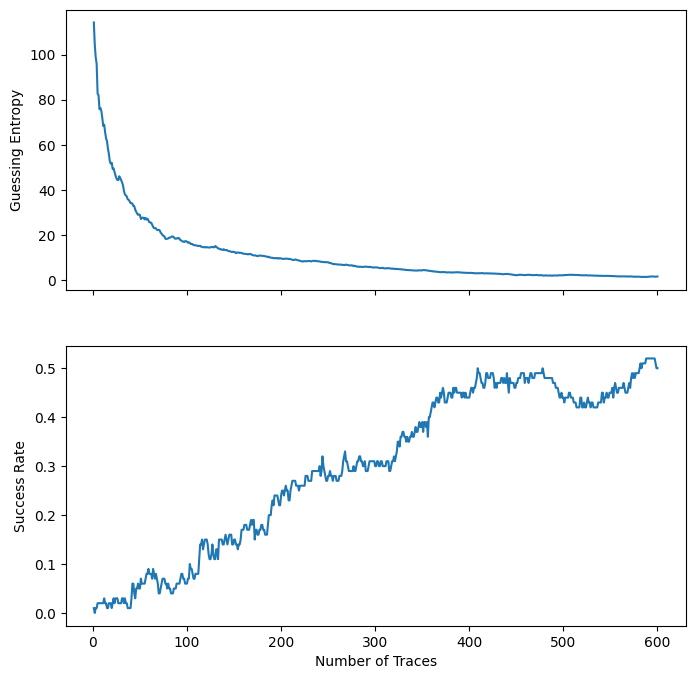

In [8]:
f, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
axs[0].plot(range(1, len(ge)+1), ge)
axs[0].set_ylabel("Guessing Entropy")
axs[1].plot(range(1, len(sr)+1), sr)
axs[1].set_ylabel("Success Rate")
axs[1].set_xlabel("Number of Traces")

plt.plot()